In [1]:
import h5py
import numpy as np
import torch
import torch.utils.data as data
from d2lLike import *
from tqdm import tqdm
from net import policyNet

In [2]:
class GoDataSet(data.Dataset):
    def __init__(self, filename):
        with h5py.File(filename, 'r', libver="latest", swmr=True) as f:
            self.inputList = f["input"][:]
            self.labelList = f["output"][:]

    def __getitem__(self, idx):
        flag = idx // len(self.labelList)
        idx = idx % len(self.labelList)
        if flag == 0:                            #不变化
            matrix = torch.from_numpy(self.inputList[idx]).to(torch.float32)
            label = torch.from_numpy(self.labelList[idx]).to(torch.float32)
            return matrix, label
        elif flag == 1:                          #左右翻转                                                      
            matrix = torch.from_numpy(self.inputList[idx]).flip(-1).to(torch.float32)
            label = torch.from_numpy(self.labelList[idx]).to(torch.float32)
            label[0:25] = label[0:25].reshape(5,5).flip(-1).reshape(25)
            return matrix, label
        elif flag == 2:                          #上下翻转
            matrix = torch.from_numpy(self.inputList[idx]).flip(-2).to(torch.float32)
            label = torch.from_numpy(self.labelList[idx]).to(torch.float32)
            label[0:25] = label[0:25].reshape(5,5).flip(-2).reshape(25)
            return matrix, label
        elif flag == 3:                          #旋转180度
            matrix = torch.from_numpy(self.inputList[idx]).flip(-1,-2).to(torch.float32)
            label = torch.from_numpy(self.labelList[idx]).to(torch.float32)
            label[0:25] = label[0:25].reshape(5,5).flip(-1,-2).reshape(25)
            return matrix, label
        elif flag == 4:                         #顺时针旋转90度
            matrix = torch.from_numpy(self.inputList[idx]).permute(0,2,1).flip(-1).to(torch.float32)
            label = torch.from_numpy(self.labelList[idx]).to(torch.float32)
            label[0:25] = label[0:25].reshape(5,5).t().flip(-1).reshape(25)
            return matrix, label
        elif flag == 5:                         #逆时针旋转90度
            matrix = torch.from_numpy(self.inputList[idx]).permute(0,2,1).flip(-2).to(torch.float32)
            label = torch.from_numpy(self.labelList[idx]).to(torch.float32)
            label[0:25] = label[0:25].reshape(5,5).t().flip(-2).reshape(25)
            return matrix, label
        elif flag == 6:                         #沿着反对角线翻转
            matrix = torch.from_numpy(self.inputList[idx]).permute(0,2,1).flip(-1, -2).to(torch.float32)
            label = torch.from_numpy(self.labelList[idx]).to(torch.float32)
            label[0:25] = label[0:25].reshape(5,5).t().flip(-1, -2).reshape(25)
            return matrix, label
        elif flag == 7:                         #沿着对角线翻转
            matrix = torch.from_numpy(self.inputList[idx]).permute(0,-1, -2).to(torch.float32)
            label = torch.from_numpy(self.labelList[idx]).to(torch.float32)
            label[0:25] = label[0:25].reshape(5,5).t().reshape(25)
            return matrix, label
    
    def __len__(self):
        return len(self.labelList) * 8

def train_Adam(net, train_iter, num_epochs, weight_decay, device, isPrint = True):
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    print('training on', device)
    net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), weight_decay = weight_decay)
    loss = nn.CrossEntropyLoss()
    if isPrint:
        animator = Animator(xlabel='epoch', xlim=[0, num_epochs],
                            legend=['train loss'])
    timer, num_batches = Timer(), len(train_iter)
    numIter = range(num_epochs) if isPrint else tqdm(range(num_epochs))
    for epoch in numIter:
        # 训练损失之和，训练准确率之和，样本数
        metric = Accumulator(2)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[1]
            if isPrint:
                if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                    animator.add(epoch + (i + 1) / num_batches, [train_l])
    print(f'loss {train_l:.3f}')
    print(f'{metric[1] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')
    return train_l

In [3]:
dataset = GoDataSet("/home/xuyisen/project/Go_game/KataGoLike/data/trainingData.hdf5")
data_iter = data.DataLoader(dataset, batch_size=32784, shuffle=True, num_workers=4)
net = policyNet()

loss 1.936
202726.8 examples/sec on cuda:0


1.93644218359375

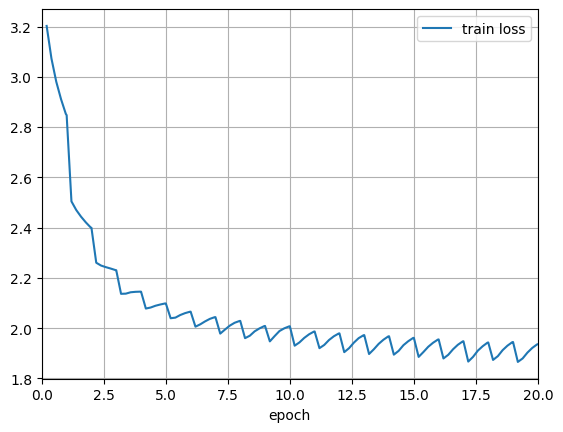

In [4]:
train_Adam(net, data_iter, 20, 0.001, torch.device('cuda:0'))

In [5]:
import onnx
import torch
import torch.nn as nn
import onnxoptimizer

fileName = "model9_1.onnx"

net.to("cpu")
net.output.append(nn.Softmax(dim=1))

net.eval()
x = torch.randn(1,5,5,5)
torch.set_default_dtype(torch.float32)
torch.onnx.export(net, x, fileName, input_names=['gameBoard'],output_names=['policy'],
                dynamic_axes={'gameBoard':{0:"batch"},'policy':{0:"batch"}})

model = onnx.load(fileName) # load the onnx model
onnx.checker.check_model(model)         # check the onnx model
model = onnxoptimizer.optimize(model)
onnx.checker.check_model(model)
onnx.save(model, fileName)

In [6]:
import onnxruntime
import numpy as np

sess = onnxruntime.InferenceSession(fileName, providers=['CPUExecutionProvider'])
x = np.zeros((1,5,5,5), dtype=np.float32)
x[0][4] = 1

output = sess.run(['policy'], {'gameBoard':x})[0][0]

In [7]:
output[0:25].reshape(5,5),output[25]

(array([[2.13124258e-05, 3.82917688e-06, 3.07925620e-05, 6.51063056e-06,
         4.77035064e-05],
        [1.24636335e-05, 3.45931512e-05, 3.80936079e-04, 1.62857075e-04,
         5.32497734e-06],
        [6.10321040e-05, 2.25681768e-04, 9.98203516e-01, 3.94588220e-04,
         5.27556040e-05],
        [1.28789088e-05, 7.09616188e-06, 1.85867873e-04, 1.60340842e-05,
         1.64059020e-05],
        [6.92020694e-06, 3.40052475e-06, 6.28543930e-05, 2.69751217e-06,
         1.28030561e-05]], dtype=float32),
 2.919329e-05)

In [9]:
output[12]

0.9982035